In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!apt install espeak
!pip -q install pydub

In [ ]:
!pip install speechrecognition
!pip install pyttsx3
!pip install wikipedia
!pip install wolframalpha
!pip install pyaudio
!pip install pywhatkit

In [ ]:
!pip install gTTS

In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import wave
import soundfile as sf
import librosa
from datetime import datetime
from logging.config import listen
import speech_recognition as sr
import pyttsx3
import webbrowser
import wikipedia
import wolframalpha
import pyaudio
from io import BytesIO
from pydub import AudioSegment
from gtts import gTTS
from IPython.display import Audio
#import pywhatkit as kt



# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
#Connecting Google Drive to Google Colab to Access the Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/qualcomm_keyword_speech_dataset')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['hey_snapdragon' 'hi_galaxy' 'hey_android' 'hi_lumina']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 4270
Number of examples per label: 1112
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/qualcomm_keyword_speech_dataset/hi_galaxy/QOKM2PIT093.wav', shape=(), dtype=string)


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = (decode_audio(audio_binary))
  return waveform, label

In [ ]:
train_files = filenames[:500]
val_files = filenames[500: 500 + 80]
test_files = filenames[-80:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 500
Validation set size 80
Test set size 80


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

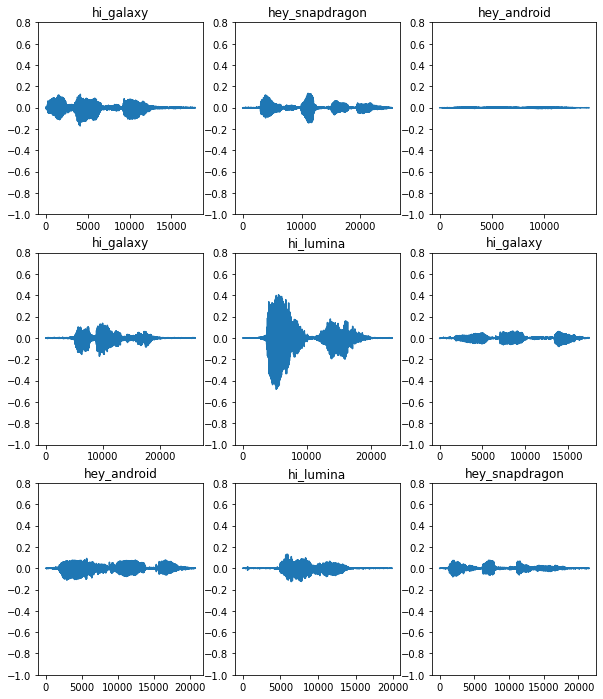

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1, 1, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([38000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: hi_galaxy
Waveform shape: (17849,)
Spectrogram shape: (295, 129)
Audio playback


<ipython-input-16-40c7c474d295>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


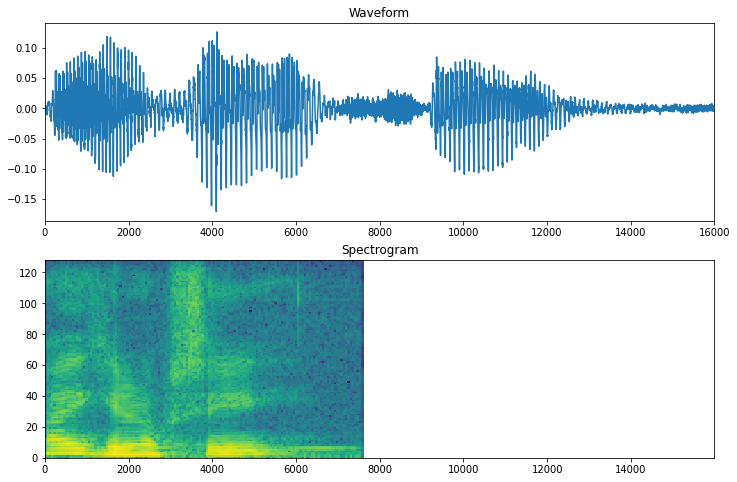

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height-74.6)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-17-40c7c474d295>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


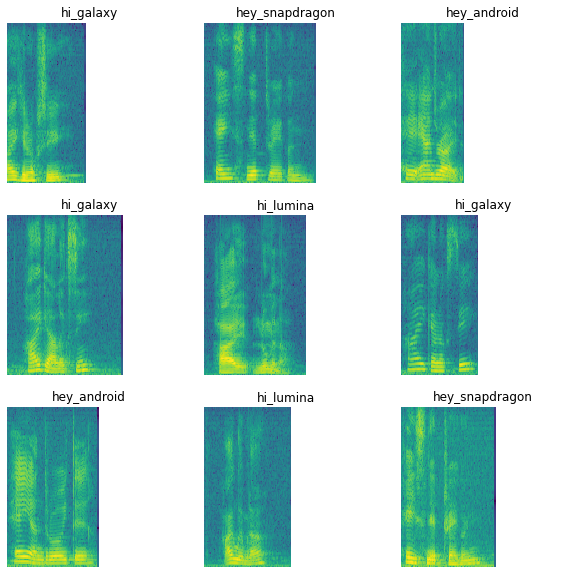

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 20
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (295, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

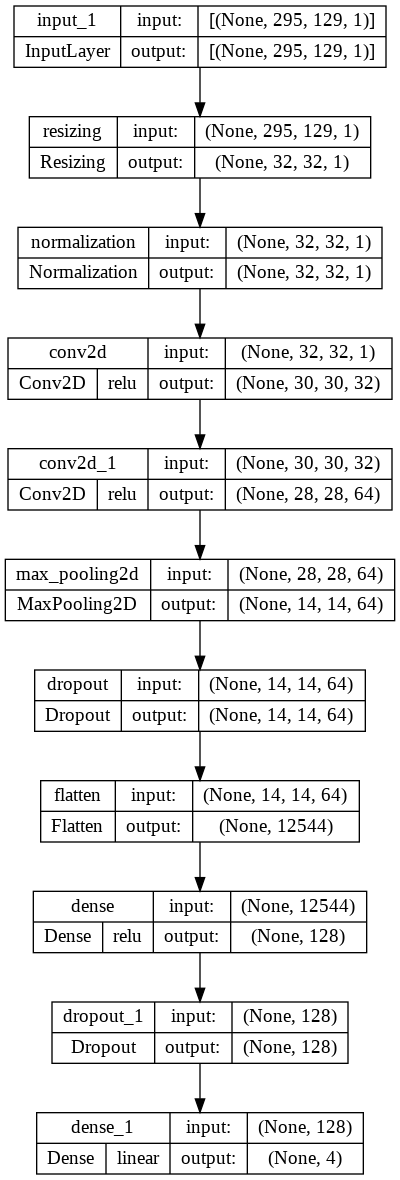

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True,show_layer_names=True, show_layer_activations=True)

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 5.0 MB/s 


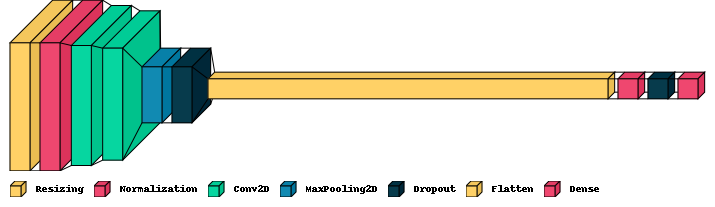

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",verbose=1, patience=2),
)

Epoch 1/10
25/25 [==============================] - 11s 415ms/step - loss: 1.1096 - accuracy: 0.5740 - val_loss: 0.7004 - val_accuracy: 0.8375
Epoch 2/10
25/25 [==============================] - 2s 87ms/step - loss: 0.6728 - accuracy: 0.7820 - val_loss: 0.4021 - val_accuracy: 0.8750
Epoch 3/10
25/25 [==============================] - 2s 86ms/step - loss: 0.4648 - accuracy: 0.8540 - val_loss: 0.3427 - val_accuracy: 0.9000
Epoch 4/10
25/25 [==============================] - 2s 89ms/step - loss: 0.3294 - accuracy: 0.9000 - val_loss: 0.3347 - val_accuracy: 0.8875
Epoch 5/10
25/25 [==============================] - 2s 91ms/step - loss: 0.3545 - accuracy: 0.9000 - val_loss: 0.2962 - val_accuracy: 0.9000
Epoch 5: early stopping


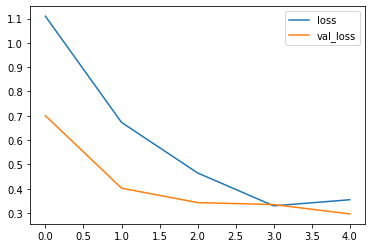

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

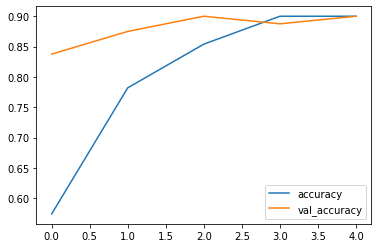

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 24ms/step
Test set accuracy: 91%


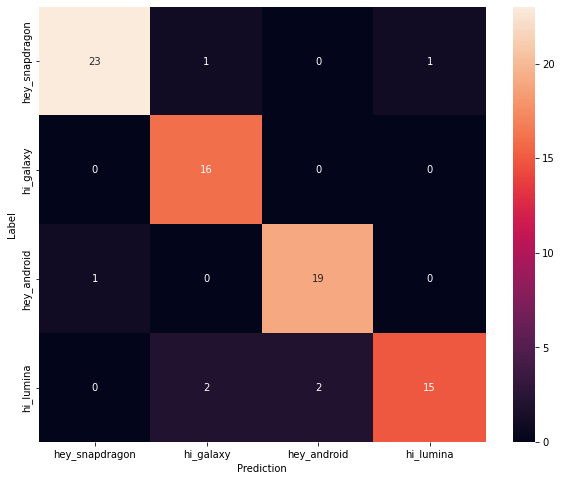

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=2):
  display.display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio_input.wav','wb') as f:
    f.write(b)
  return 'audio_input.wav'

In [ ]:
audio=record()
file_path = "/content/audio_input.wav"
x,_ = librosa.load('/content/audio_input.wav', sr=16000)
sf.write('tmp.wav', x, 16000)
wave.open('tmp.wav','r')

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
display.display(display.Audio(audio, rate=16000))

In [ ]:
loaded_model=models.load_model("/content/drive/MyDrive/saved_model")

In [ ]:
sample_file = '/content/tmp.wav'

sample_ds = preprocess_dataset([str(sample_file)])
obj=wave.open(str(sample_file),'rb')
n_samples=obj.getnframes()
signal_wave=obj.readframes(n_samples)
signal_array=np.frombuffer(signal_wave,dtype=np.int16)
obj.close()

print(signal_array.shape)

(29760,)


tf.Tensor([[ 2.3220053  -1.3192483   0.27632698  0.69197035]], shape=(1, 4), dtype=float32)
hey_snapdragon
['hey_snapdragon' 'hi_galaxy' 'hey_android' 'hi_lumina'] tf.Tensor([0.73995435 0.0194012  0.09567051 0.14497387], shape=(4,), dtype=float32)


<function matplotlib.pyplot.show(*args, **kw)>

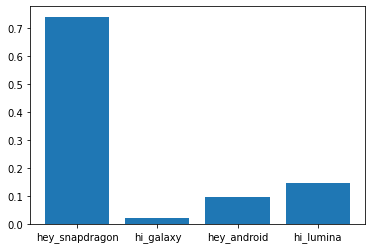

In [ ]:
waveform=signal_array/49000
waveform=tf.convert_to_tensor(waveform,dtype=tf.float32)
spec=get_spectrogram(waveform)
spec=tf.expand_dims(spec,0)
prediction=model(spec)
print(prediction)

label_pred=np.argmax(prediction,axis=1)
print(commands[label_pred[0]])
print(commands,tf.nn.softmax(prediction[0]))
plt.bar(commands,tf.nn.softmax(prediction[0]))
plt.show


In [ ]:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[0].id) # 0 = male, 1 = female
activationWord = 'system' # Single word

# Configure browser
# Set the path
chrome_path = r"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe"
webbrowser.register('chrome', None, webbrowser.BackgroundBrowser(chrome_path))

# Wolfram Alpha client
appId = '5R49J7-J888YX9J2V'
wolframClient = wolframalpha.Client(appId)

def speak(text, rate = 120):
    engine.setProperty('rate', rate)
    engine.say(text)
    engine.runAndWait()

def parseCommand():
    listener = sr.Recognizer()
    print('Listening for a command')

    audio_com=record()
    x,_ = librosa.load(file_path, sr=16000)
    sf.write('tmp.wav', x, 16000)
    wave.open('tmp.wav','r')

    with sr.WavFile('/content/tmp.wav') as source:
      input_speech=listener.record(source)

    try:
        print('Recognizing speech...')
        query = listener.recognize_google(input_speech, language='en_us')
        print(f'The input speech was: {query}')
    except Exception as exception:
        print('I did not quite catch that')
        say=gTTS(text='I did not quite catch that', lang="en", slow=False)
        say.save("example.wav")
        sound_file = 'example.wav'
        Audio(sound_file, autoplay=True)
        speak('I did not quite catch that')
        print(exception)
        return 'None'

    return query

def search_wikipedia(query = ''):
    searchResults = wikipedia.search(query)
    if not searchResults:
        print('No wikipedia result')
        return 'No result received'
    try:
        wikiPage = wikipedia.page(searchResults[0])
    except wikipedia.DisambiguationError as error:
        wikiPage = wikipedia.page(error.options[0])
    print(wikiPage.title)
    wikiSummary = str(wikiPage.summary)
    return wikiSummary

def listOrDict(var):
    if isinstance(var, list):
        return var[0]['plaintext']
    else:
        return var['plaintext']

def search_wolframAlpha(query = ''):
    response = wolframClient.query(query)

    # @success: Wolfram Alpha was able to resolve the query
    # @numpods: Number of results returned
    # pod: List of results. This can also contain subpods
    if response['@success'] == 'false':
        return 'Could not compute'

    # Query resolved
    else:
        result = ''
        # Question
        pod0 = response['pod'][0]
        pod1 = response['pod'][1]
        # May contain the answer, has the highest confidence value
        # if it's primary, or has the title of result or definition, then it's the official result
        if (('result') in pod1['@title'].lower()) or (pod1.get('@primary', 'false') == 'true') or ('definition' in pod1['@title'].lower()):
            # Get the result
            result = listOrDict(pod1['subpod'])
            # Remove the bracketed section
            return result.split('(')[0]
        else:
            question = listOrDict(pod0['subpod'])
            # Remove the bracketed section
            return question.split('(')[0]
            # Search wikipedia instead
            speak('Computation failed. Querying universal databank.')
            return search_wikipedia(question)

In [ ]:
if ((commands[label_pred[0]])=="hey_snapdragon"):
  print("listening...")


listening...


In [ ]:
if ((commands[label_pred[0]])=="hey_snapdragon"):
    speak('All systems nominal.')

    while True:
        # Parse as a list
        query = parseCommand().lower().split()

        if query[0] == activationWord:
            query.pop(0)

            # List commands
            if query[0] == 'say':
                if 'hello' in query:
                    speak('Greetings, all.')
                    print('Greetings, all.')
                else:
                    query.pop(0) # Remove say
                    speech = ' '.join(query)
                    speak(speech)

            # Navigation
            if query[0] == 'go' and query[1] == 'to':
                speak('Opening...')
                query = ' '.join(query[2:])
                webbrowser.get('chrome').open_new(query+".com")

            # Wikipedia
            if query[0] == 'wikipedia':
                query = ' '.join(query[1:])
                speak('Querying the universal databank.')
                speak(search_wikipedia(query))

            # Wolfram Alpha
            if query[0] == 'compute' or query[0] == 'computer':
                query = ' '.join(query[1:])
                speak('Computing')
                try:
                    result = search_wolframAlpha(query)
                    speak(result)
                    print(result)
                except:
                    speak('Unable to compute.')

            # Note taking
            if query[0] == 'log':
                speak('Ready to record your note')
                newNote = parseCommand().lower()
                now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
                with open('note_%s.txt' % now, 'w') as newFile:
                    newFile.write(newNote)
                speak('Note written')

            if query[0] == 'exit':
                speak('Goodbye')
                break

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
{   'alternative': [   {'confidence': 0.74209619, 'transcript': 'a Snapdragon'},
                       {'transcript': 'Eastern Dragon'}],
    'final': True}
The input speech was: a Snapdragon
Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Recognizing speech...
result2:
[]
I did not quite catch that

Listening for a command


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
loaded_model=models.load_model("saved_model2")

In [ ]:
model.save("saved_model2")

In [ ]:
!zip -r ./saved_model2.zip ./saved_model2

  adding: saved_model2/ (stored 0%)
  adding: saved_model2/saved_model.pb (deflated 88%)
  adding: saved_model2/variables/ (stored 0%)
  adding: saved_model2/variables/variables.index (deflated 64%)
  adding: saved_model2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model2/assets/ (stored 0%)
  adding: saved_model2/keras_metadata.pb (deflated 90%)
